<a href="https://colab.research.google.com/github/mohsenperfection/ML/blob/CHW03/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 99102083
Name = 'Mohsen'
Last_Name = 'Kamalabadi Farahani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [2]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

## Importing Libraries

In [3]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [4]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 19229573.43it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 334372.01it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6242037.48it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15291980.87it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [5]:
## FILL HERE
# input_dim = .....
num_classes = len(train_set.classes)
input_dim = train_set[0][0].numel()

print(f"Number of classes: {num_classes}")
print(f"Input dimension: {input_dim}")

Number of classes: 10
Input dimension: 784


In [6]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

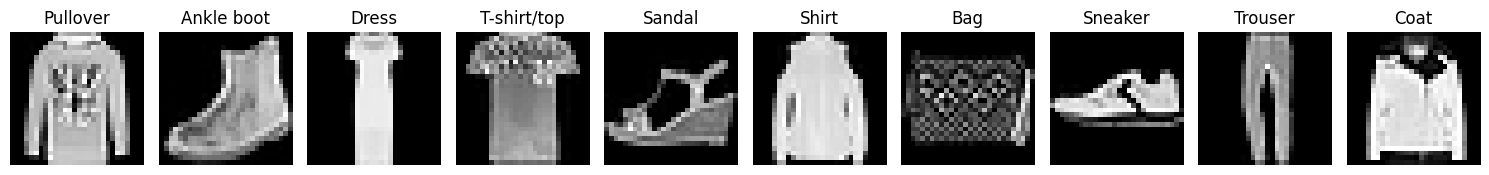

In [7]:
class_images = {}

for images, labels in train_loader:
    for i in range(images.size(0)):
        label = labels[i].item()
        if label not in class_images:
            class_images[label] = images[i]
        if len(class_images) == num_classes:
            break
    if len(class_images) == num_classes:
        break

fig, axes = plt.subplots(1, num_classes, figsize=(15, 15))

class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i, (label, image) in enumerate(class_images.items()):
    ax = axes[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_labels[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [8]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [9]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [10]:
def affine_forward(x, w, b):
    """
    Computes the affine transformation (Wx + b).
    x: input tensor of shape (N, d_in)
    w: weights tensor of shape (d_in, d_out)
    b: bias tensor of shape (d_out)
    """
    return x @ w + b

def relu(x):
    """
    Applies the ReLU activation function element-wise.
    x: input tensor
    """
    return torch.maximum(x, torch.zeros_like(x))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [12]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)  # Flatten the input

    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        x = affine_forward(x, w, b)

        if i < num_layers - 1:
            x = relu(x)

    output = x
    return output

Implementing cross entropy loss:

In [13]:
def cross_entropy_loss(scores, y):
    """
    Computes the cross entropy loss.

    scores: Tensor of shape (N, C) where N is the batch size and C is the number of classes.
    y: Tensor of shape (N,) where each value is the true class label for each sample.

    Returns:
    loss: Scalar tensor representing the average cross entropy loss over the batch.
    """
    n = len(y)
    exp_scores = torch.exp(scores)
    probabilities = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    log_probabilities = torch.log(probabilities)
    correct_log_probabilities = log_probabilities[range(n), y]
    loss = -torch.mean(correct_log_probabilities)

    return loss


Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [14]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for param in parameters.values():
        if param.requires_grad:
            param.data -= learning_rate * param.grad

            param.grad.zero_()

Training functions:

In [15]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    correct_predictions = np.sum(y_pred == y_true)
    total_predictions = len(y_true)
    acc = correct_predictions / total_predictions
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        loss = cross_entropy_loss(p, y)
        train_loss += loss.item()
        loss.backward()
        sgd_optimizer(parameters, learning_rate)

        if (i + 1) % 10 == 0 or (i + 1) == len(train_loader):
            print(f'Epoch [{epoch}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    train_loss /= len(train_loader)
    print(f'Accuracy of train set: {acc * 100:.2f}%')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally, the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item()

        print(f'Epoch [{epoch}], Batch [{i+1}/{len(loader)}], {set_name} Loss: {loss.item():.4f}')

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    total_loss /= len(loader)

    print(f'Accuracy of {set_name} set: {acc * 100:.2f}%')

    return total_loss, acc

In [16]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [17]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = validate(test_loader, epoch, set_name='test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}% - '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.tight_layout()
    plt.show()

Streaming output truncated to the last 5000 lines.
Epoch [5], Batch [810/938], Loss: 0.7661
Epoch [5], Batch [820/938], Loss: 0.6928
Epoch [5], Batch [830/938], Loss: 0.6331
Epoch [5], Batch [840/938], Loss: 0.6928
Epoch [5], Batch [850/938], Loss: 0.6757
Epoch [5], Batch [860/938], Loss: 0.5673
Epoch [5], Batch [870/938], Loss: 0.7624
Epoch [5], Batch [880/938], Loss: 0.7653
Epoch [5], Batch [890/938], Loss: 0.7252
Epoch [5], Batch [900/938], Loss: 0.5914
Epoch [5], Batch [910/938], Loss: 0.3798
Epoch [5], Batch [920/938], Loss: 0.7412
Epoch [5], Batch [930/938], Loss: 0.5696
Epoch [5], Batch [938/938], Loss: 0.6175
Accuracy of train set: 74.10%
Epoch [5], Batch [1/157], test Loss: 0.7845
Epoch [5], Batch [2/157], test Loss: 0.6860
Epoch [5], Batch [3/157], test Loss: 0.7108
Epoch [5], Batch [4/157], test Loss: 0.6264
Epoch [5], Batch [5/157], test Loss: 0.7030
Epoch [5], Batch [6/157], test Loss: 0.7381
Epoch [5], Batch [7/157], test Loss: 0.5967
Epoch [5], Batch [8/157], test Loss: 

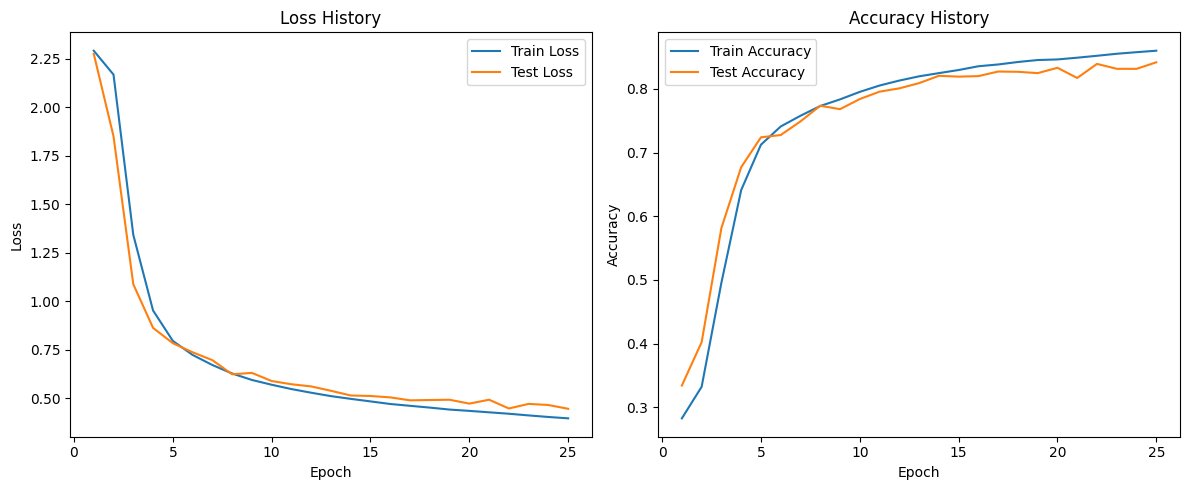

In [18]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [19]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8418


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

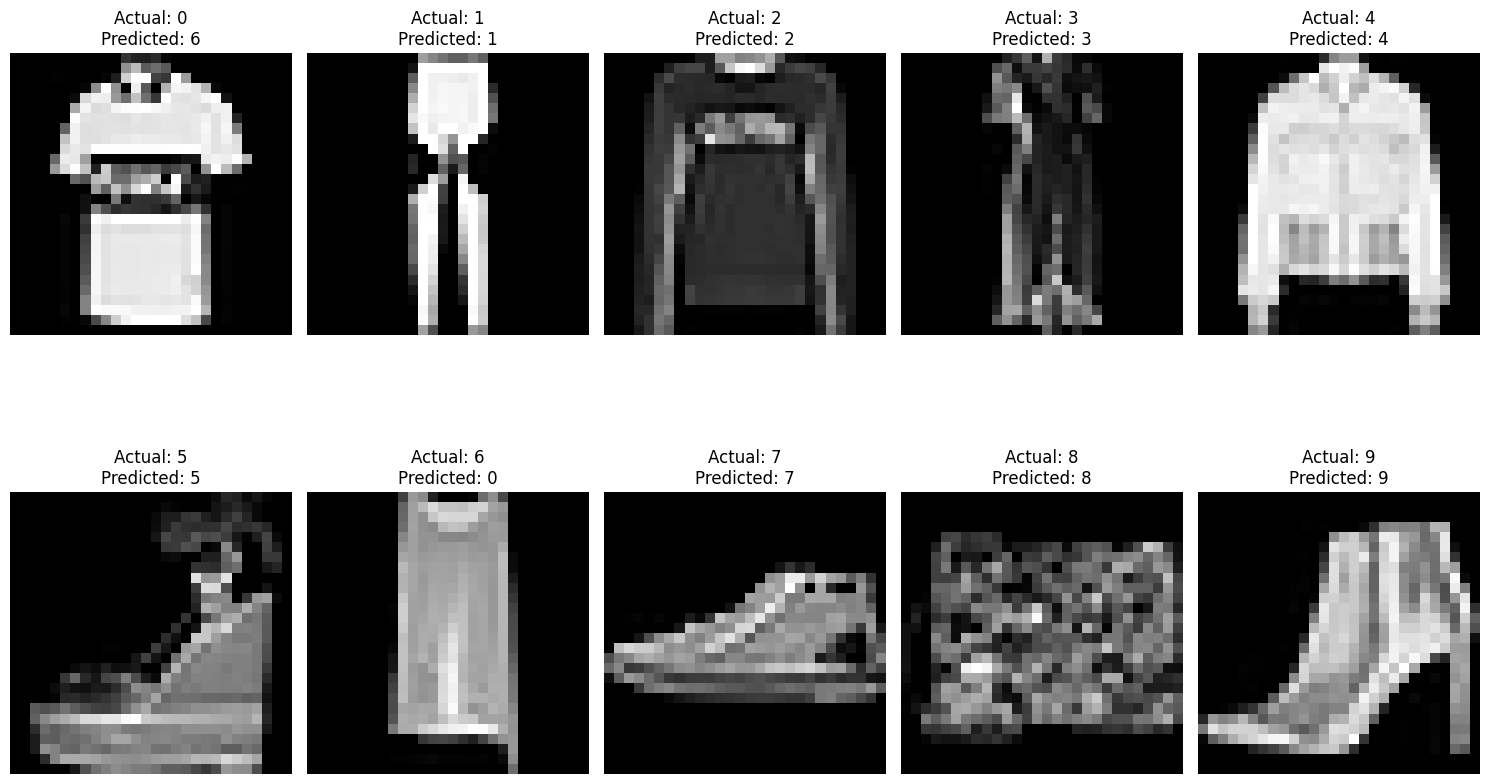

In [20]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, parameters):
    class_images = {}

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x, parameters)
            _, preds = torch.max(outputs, 1)

            for img, label, pred in zip(x, y, preds):
                if label.item() not in class_images:
                    class_images[label.item()] = (img, pred.item())

                if len(class_images) == 10:
                    break

    plt.figure(figsize=(15, 10))
    for i in range(10):
        img, pred = class_images[i]
        img = img.cpu().numpy().squeeze()
        actual_label = i
        predicted_label = pred

        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, parameters)